In [2]:
import zipfile

import sys
import os

# Subir un nivel al path
sys.path.append(os.path.abspath(".."))
from redes import FaceClassifierNN, FaceClassifier2NN

with zipfile.ZipFile('../Test.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [19]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from skimage.feature import hog
import xgboost as xgb
from sklearn.metrics import accuracy_score
import torch
from sklearn.pipeline import Pipeline

In [4]:
suffix = '.pgm'
kaggle_files = os.listdir('Test')
pgm_kaggle_files = [filename for filename in kaggle_files if filename.endswith(suffix)]

In [5]:
len(pgm_kaggle_files)

8000

In [6]:

def imgs_to_hog(imgs):
    hog_features_test = []
    for img in tqdm(imgs, desc='Extrayendo HOG features'):
        fd = hog(img, visualize=False)
        hog_features_test.append(fd)

        #transformamos en array y stackeamos
    ret_array = np.array(hog_features_test)
    ret_array = np.vstack(hog_features_test)

    return ret_array

In [7]:
kaggle_patches = []
for filename in tqdm(pgm_kaggle_files):
  path = 'Test/' + filename
  with open(path, 'rb') as pgmf:
      image = plt.imread(pgmf)
  kaggle_patches.append(image)

100%|██████████| 8000/8000 [01:39<00:00, 80.19it/s] 


In [8]:
pgm_kaggle_files_id = []

for filename in tqdm(pgm_kaggle_files):
  pgm_kaggle_files_id.append(filename[5:-4])

100%|██████████| 8000/8000 [00:00<00:00, 1442580.91it/s]


Para cargar modelo ML

In [55]:
scaler = joblib.load('../modelos/scaler_20250701.pkl') 
pca_model = joblib.load('../modelos/pca_20250701.pkl') 


In [63]:
# Aquí debe utilizar su modelo 
model_1 = joblib.load('../modelos/pipeline_LReg_20250701.pkl') 
model_2 = joblib.load('../modelos/pipeline_XGB_20250701.pkl')    

In [64]:
model_1

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=np.int64(459))),
                ('clf',
                 LogisticRegression(C=0.1, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [65]:
model_2

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=np.int64(459))),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

Para cargar Red

In [59]:
modelo_3 = FaceClassifier2NN()
modelo_3.load_state_dict(torch.load('../modelos/nn_20250701.pth')) 

<All keys matched successfully>

In [60]:
modelo_3.eval()

FaceClassifier2NN(
  (network): Sequential(
    (0): Linear(in_features=459, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [61]:
pgm_kaggle_array = np.stack(kaggle_patches)
pgm_kaggle_array = pgm_kaggle_array / 255.0  # Normalizar las imágenes
pgm_kaggle_array = imgs_to_hog(pgm_kaggle_array)  # Extraer características HOG
kaggle_images_flatten = np.array([im.flatten() for im in tqdm(pgm_kaggle_array, desc='Construyendo X')])

Construyendo X: 100%|██████████| 8000/8000 [00:00<00:00, 60212.38it/s]


In [66]:
proba_logreg = model_1.predict_proba(kaggle_images_flatten)[:, 1]

In [67]:
proba_xgb = model_2.predict_proba(kaggle_images_flatten)[:, 1]

In [68]:
X_pca_nn = pca_model.transform(scaler.transform(kaggle_images_flatten))

In [69]:
modelo_3.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X_pca_nn, dtype=torch.float32)
    proba_nn = torch.sigmoid(modelo_3(X_tensor)).squeeze().numpy()

In [70]:
proba_nn

array([3.0224647e-09, 1.8673538e-09, 1.0282627e-14, ..., 6.0011095e-19,
       7.0796709e-08, 4.2938165e-08], shape=(8000,), dtype=float32)

In [103]:
# Promedio simple de las 3 probabilidades
proba_ensemble = (proba_logreg + proba_xgb + proba_nn) / 3

In [80]:
voto_mayoritario = ((proba_logreg >= 0.5).astype(int) + (proba_xgb >= 0.5).astype(int) + (proba_nn >= 0.5).astype(int) >= 2).astype(int)

In [104]:
# Predicción final con umbral 0.5
y_pred_ensemble = (proba_ensemble >= 0.8).astype(int)

Cantidad de imágenes con desacuerdo entre modelos: 36


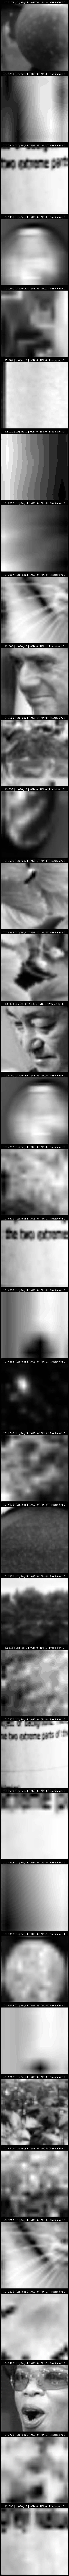

In [105]:
# Encontrar los índices donde los modelos discrepan
pred_logreg = (proba_logreg >= 0.5).astype(int)
pred_xgb = (proba_xgb >= 0.5).astype(int)
pred_nn = (proba_nn >= 0.5).astype(int)

# Índices donde hay al menos una diferencia entre los modelos
diff_idx = np.where((pred_logreg != pred_xgb) | (pred_logreg != pred_nn) | (pred_xgb != pred_nn))[0]

print(f"Cantidad de imágenes con desacuerdo entre modelos: {len(diff_idx)}")

# Mostrar todas las imágenes donde los modelos discrepan
num_to_show = len(diff_idx)
plt.figure(figsize=(5, 5 * num_to_show))
for i, idx in enumerate(diff_idx):
    plt.subplot(num_to_show, 1, i + 1)
    plt.imshow(kaggle_patches[idx], cmap='gray')
    plt.title(
        f"ID: {pgm_kaggle_files_id[idx]} | LogReg: {pred_logreg[idx]} | XGB: {pred_xgb[idx]} | NN: {pred_nn[idx]} | Predicción: {y_pred_ensemble[idx]}"
    )
    plt.axis('off')
plt.tight_layout()
plt.show()

Cantidad de imágenes con desacuerdo entre modelo_2 y voto_mayoritario: 5


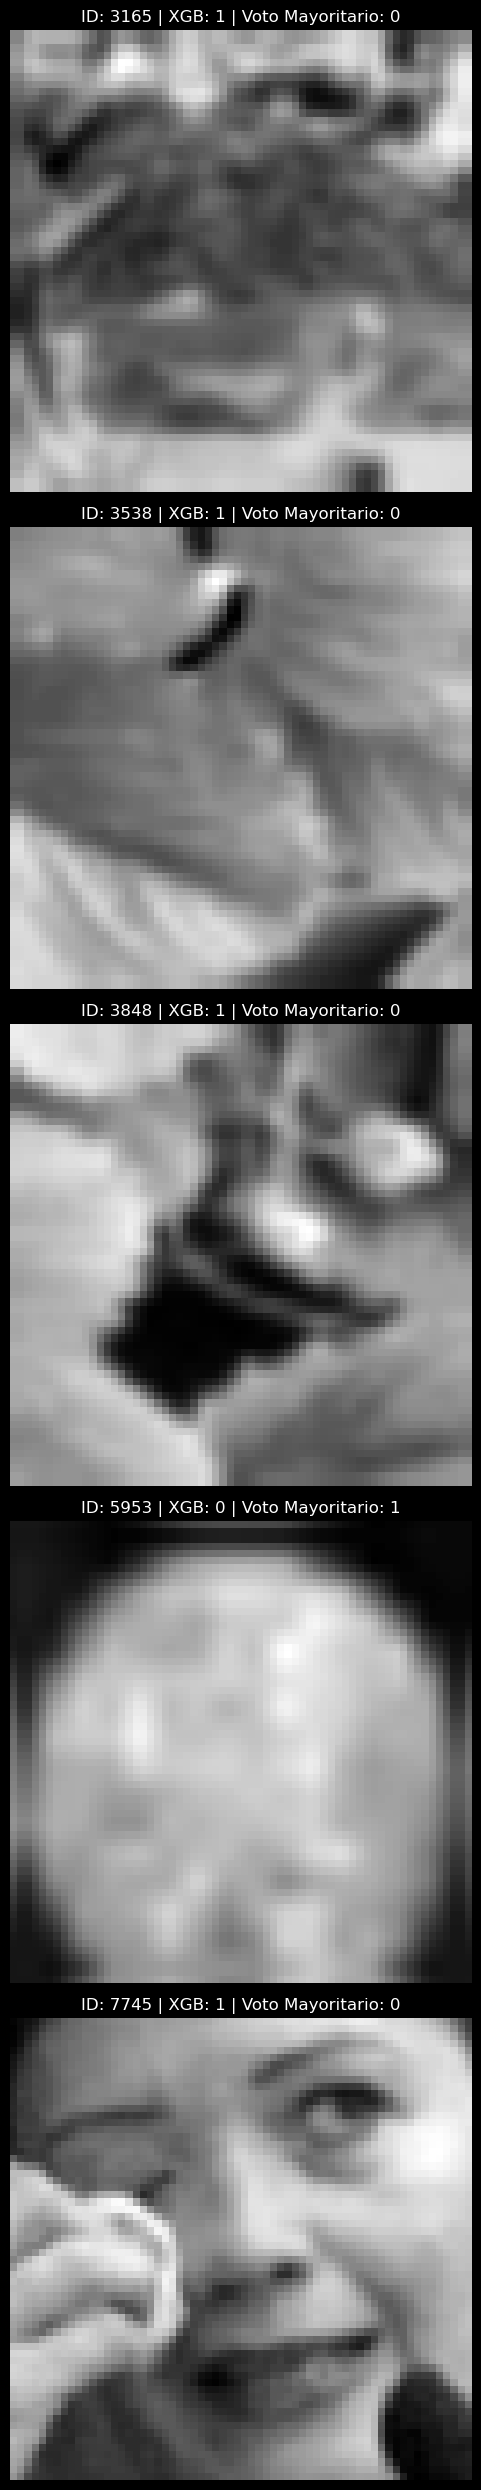

In [98]:
# Índices donde modelo_2 y voto_mayoritario discrepan
diff_xgb_vs_voto = np.where(pred_xgb != y_pred_ensemble)[0]

print(f"Cantidad de imágenes con desacuerdo entre modelo_2 y voto_mayoritario: {len(diff_xgb_vs_voto)}")

# Mostrar todas las imágenes donde hay diferencia
num_to_show = len(diff_xgb_vs_voto)
plt.figure(figsize=(5, 5 * num_to_show))
for i, idx in enumerate(diff_xgb_vs_voto):
    plt.subplot(num_to_show, 1, i + 1)
    plt.imshow(kaggle_patches[idx], cmap='gray')
    plt.title(
        f"ID: {pgm_kaggle_files_id[idx]} | XGB: {pred_xgb[idx]} | Voto Mayoritario: {y_pred_ensemble[idx]}"
    )
    plt.axis('off')
plt.tight_layout()
plt.show()

In [81]:
y_pred_ensemble = voto_mayoritario

In [99]:
# Predicción + ID
y_kag_dic = {pgm_kaggle_files_id[i]: y_pred_ensemble[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)

In [100]:
kaggle_hat.value_counts('target_feature')

target_feature
0    7604
1     396
Name: count, dtype: int64

Prediccion con modelo de ML

In [50]:
# Predicción
y_kag = model.predict(X_pca_kag)

NameError: name 'model' is not defined

Prediccion con Red Neuronal

In [15]:
X_unlabeled_tensor = torch.tensor(X_pca_kag, dtype=torch.float32)

In [16]:
with torch.no_grad():
    logits = modelo(X_unlabeled_tensor).squeeze()
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).int()

In [17]:
y_kag = preds.numpy()

In [18]:
# Predicción + ID
y_kag_dic = {pgm_kaggle_files_id[i]: y_kag[i] for i in range(len(pgm_kaggle_files_id))}
kaggle_hat = pd.DataFrame(list(y_kag_dic.items()), columns=['id', 'target_feature'])
kaggle_hat['id'] = kaggle_hat['id'].astype(int)
kaggle_hat['target_feature'] = kaggle_hat['target_feature'].astype(int)
kaggle_hat.sort_values(by='id', inplace=True)

In [19]:
kaggle_hat.head()

,id,target_feature
0,0,0
1,1,0
1112,2,0
2223,3,0
3334,4,0


In [95]:
kaggle_hat.value_counts('target_feature')

target_feature
0    7597
1     403
Name: count, dtype: int64

In [101]:
# Guardamos en un .csv para subir a kaggle
submission_name = 'prueba_ensemble_20250701_v4'  # Cambiar el nombre del archivo según sea necesario
kaggle_hat.to_csv('../submissions/'+ submission_name + '.csv', index=False)